In [7]:
# Read data
import pandas as pd
import numpy as np
df = pd.read_csv("./MLC_SP23/clean_data/regression_data.csv", low_memory=False, index_col=[0])
df.head()

,bbl,rs_share_diff,total_units_19,year_built,ejectment_count,possession_count,eviction_count,aleration_count,altered_lessthan5yrs,altered_morethan5yrs,...,pop_race_div_idx_19,boro_2,boro_3,boro_4,boro_5,hh_inc_avg_19_log1,pop_race_asian_pct_19_log1,pop_race_black_pct_19_log1,pop16_unemp_pct_19_log1,pop_mobile1_diff_state_pct_19_log1
0,1000780047,0.0000,483,2016,0.0,0.0,0.0,0.0,0.0,0.0,...,0.450691,0,0,0,0,12.276639,0.150551,0.018246,0.035008,0.074674
1,1001350019,0.0000,4,1915,0.0,0.0,0.0,0.0,0.0,0.0,...,0.457072,0,0,0,0,12.897523,0.096864,0.055298,0.002253,0.014341
2,1001620013,-0.0500,20,1915,0.0,0.0,0.0,0.0,0.0,0.0,...,0.612518,0,0,0,0,10.973689,0.461379,0.096629,0.037102,0.008935
3,1001630024,0.1875,16,1915,0.0,0.0,0.0,0.0,0.0,0.0,...,0.612518,0,0,0,0,10.973689,0.461379,0.096629,0.037102,0.008935
4,1001630033,0.0000,11,1915,0.0,0.0,0.0,1.0,0.0,1.0,...,0.612518,0,0,0,0,10.973689,0.461379,0.096629,0.037102,0.008935


In [8]:
df.columns

Index(['bbl', 'rs_share_diff', 'total_units_19', 'year_built',
       'ejectment_count', 'possession_count', 'eviction_count',
       'aleration_count', 'altered_lessthan5yrs', 'altered_morethan5yrs',
       'classanet_avg', 'enlargement_count', 'hpd_calls_2017',
       'hpd_calls_2018', 'hpd_calls_2019', 'dob_calls_2017', 'dob_calls_2018',
       'dob_calls_2019', 'b_violations_2017', 'b_violations_2018',
       'b_violations_2019', 'c_violations_2017', 'c_violations_2018',
       'c_violations_2019', 'cases_2017', 'cases_2018', 'cases_2019',
       'Heat and Hot Water_2017', 'Heat and Hot Water_2018',
       'Heat and Hot Water_2019', 'Tenant Action_2017', 'Tenant Action_2018',
       'Tenant Action_2019', 'CONH_2017', 'CONH_2018', 'CONH_2019',
       'Tenant Action/Harrassment_2017', 'Tenant Action/Harrassment_2018',
       'Tenant Action/Harrassment_2019', 'hh_inc_own_med_19',
       'own_cost_mort_med_19', 'own_burden_mort_med_19',
       'rent_contract_med_19', 'rent_burden_med_1

# Train-test split

In [9]:
X = df.drop(['rs_share_diff', 'bbl'], axis = 1)
y = df['rs_share_diff']

In [10]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=1)

In [30]:
# Mean change in rs share
df['rs_share_diff'].mean()

-0.18852586470668642

In [29]:
# Mean change for large bldgs
df[df['total_units_19'] >= 7]['rs_share_diff'].mean()

-0.04442327408607823

In [31]:
# Mean change for small bldgs
df[df['total_units_19'] < 7]['rs_share_diff'].mean()

-0.737278916844144

# Random forest classifier

In [12]:
# Fit model
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
import time

scoring = {'r2':'r2',
           'mse':'neg_mean_squared_error'
}

param_grid = {'max_depth':[2, 4, 6],
              'n_estimators': [100, 200, 300]
}

start = time.time()

rf = RandomForestRegressor(random_state = 1)
gr = GridSearchCV(rf, param_grid = param_grid, scoring = scoring, refit = "mse", cv = 4)
fit = gr.fit(X_train, y_train)

end = time.time()

print("Running grid search took", end - start, "seconds") # time in seconds to run grid search
print()
print(fit.best_params_)
print(fit.best_score_)

Running grid search took 617.0811688899994 seconds

{'max_depth': 6, 'n_estimators': 100}
-0.11243602252260058


In [26]:
best_params_index = fit.cv_results_['rank_test_mse'][0] - 1
best_params_index
print("Best model mse:", fit.cv_results_['mean_test_mse'][best_params_index])
print("Best model R-squared:", fit.cv_results_['mean_test_r2'][best_params_index])

Best model mse: -0.11247297926487126
Best model R-squared: 0.44856397187915137


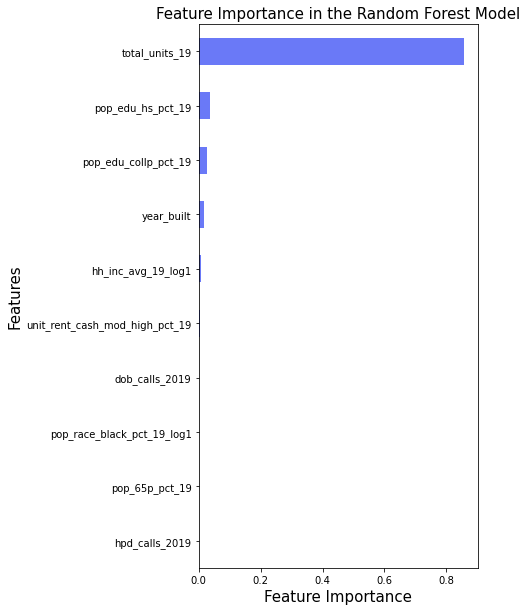

In [27]:
# get feature importance
from matplotlib import pyplot as plt
from matplotlib.pyplot import cm

plt.figure(figsize=(5,10))
importances = pd.Series(fit.best_estimator_.feature_importances_, X_train.columns)
importances.sort_values().tail(10).plot.barh(color = '#6a79f7')
plt.title('Feature Importance in the Random Forest Model',fontsize=15)
plt.xlabel('Feature Importance',fontsize = 15)
plt.ylabel('Features',fontsize = 15)
plt.show()

In [ ]:
# next steps:
# score on rmse
# make 'per 100 unit' columns - see Random Forest large bldgs only script
# try separate models by bldg size (or create flag and model on that)
# more grid searches?
# look at predictions by bldg size- how does it translate to total losses of rs units?